# Example: Monotonic 1d function

In [1]:
import numpy as np
import scipy.linalg as la
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
np.random.seed(12345)

In [3]:
ell = 0.5**2
def psi0(x):
    return np.exp(-x**2/(2*ell))

def psi1(x):
    return -1/ell*x*np.exp(-x**2/(2*ell))
    
def psi2(x):
    return (x**2-ell)/(ell**2)*np.exp(-x**2/(2*ell))

def psi3(x):
    return (-x**3+3*x*ell)/(ell**3)*np.exp(-x**2/(2*ell))

def psi4(x):
    return (x**4-6*x**2*ell+3*ell**2)/(ell**4)*np.exp(-x**2/(2*ell))

## Target function and data set

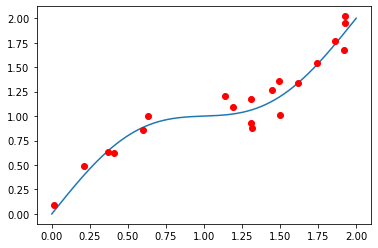

In [4]:
x_low = 0
x_high = 2
n_samples = 20
b_noise_true = 0.2
b_noise = b_noise_true
f_low = -1
f_high = 3
xs = np.linspace(x_low, x_high, 1000)

def f_target(x):
    return x+0.3*np.sin(np.pi*x)

ys = f_target(xs)

xs_train = np.sort(np.random.uniform(low=x_low, high=x_high, size=n_samples))
ys_train = f_target(xs_train) + np.random.uniform(low=-b_noise_true, high=b_noise_true, size=n_samples)

plt.plot(xs,ys)
plt.plot(xs_train, ys_train, 'ro')

### Use geo-SOC for nice predictor

In [5]:
# Get eta
# We use the approach from https://github.com/PCAubin/Hard-Shape-Constraints-for-Kernels/blob/main/code/ToyQuadratic_MonotonousLeastSquares.m
xs_local = np.linspace(0, 10*ell, 1000)
psi1_local = psi1(xs_local)
delta_max = xs_local[np.argmin(psi1_local[1:]-psi1_local[:-1]<0)]

# Virtual points (grid used for SOC)
n_grid = 100
xs_grid = np.linspace(0,2,n_grid)
delta = xs_grid[1]-xs_grid[0]
eta = np.sqrt(-2*psi2(0)+2*psi2(delta))

# Gram-like matrices from RT
K0 = psi0(xs_train.reshape([-1,1])-xs_train.reshape([1,-1]))
K01 = psi1(xs_train.reshape([-1,1])-xs_grid.reshape([1,-1]))
K11 = psi2(xs_grid.reshape([-1,1])-xs_grid.reshape([1,-1]))
K = np.block([
    [K0   , K01],
    [K01.T, -K11]
]) + 10e-5*np.identity(n_samples+n_grid)
K2 = np.hstack([psi1(xs_grid.reshape([-1,1])-xs_train.reshape([1,-1])), 
                -psi2(xs_grid.reshape([-1,1])-xs_grid.reshape([1,-1]))])

alpha = cp.Variable([n_samples+n_grid,1])
constraints_data = [cp.abs(K[:n_samples,:]@alpha - ys_train.reshape([-1,1])) <= b_noise*np.ones([n_samples,1])]
Ksqrt = la.sqrtm(K)
constraints_diff = [cp.SOC(K2[i,:] @ alpha, eta*Ksqrt@alpha) for i in range(n_grid)]
#constraints_diff = K2@alpha >= eta*alpha.T @ K @ alpha*np.ones([n_grid,1])
prob = cp.Problem(cp.Minimize(cp.quad_form(alpha, K)), constraints_data + constraints_diff)

prob.solve(solver=cp.MOSEK)

4.337611453667812

### Hard optimal uncertainty sets

In [6]:
def ub(x):
    if x > xs_train[-1]:
        return f_high
    return np.min(ys_train[np.argwhere(xs_train >= x)] + b_noise)

def lb(x):
    if x < xs_train[0]:
        return f_low
    return np.max(ys_train[np.argwhere(xs_train <= x)] - b_noise)

### Plot

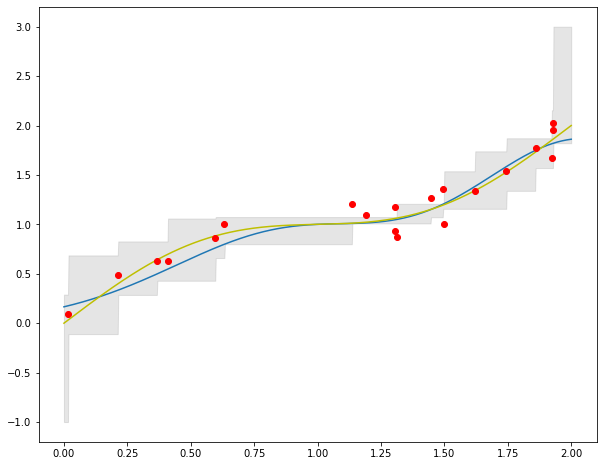

In [7]:
alpha_pred = alpha.value
xsx = np.hstack([xs_train, xs_grid])
K_plot = np.hstack([psi0(xs.reshape([-1,1])-xs_train.reshape([1,-1])), psi1(xs.reshape([-1,1])-xs_grid.reshape([1,-1]))])
plt.figure(figsize=(10,8))
plt.plot(xs, K_plot@alpha_pred)
plt.plot(xs, ys, '-y')
plt.plot(xs_train, ys_train, 'ro')

#plt.plot(xs, [ub(x) for x in xs], 'k')
#plt.plot(xs, [lb(x) for x in xs], 'k')
plt.fill_between(xs, [lb(x) for x in xs], [ub(x) for x in xs], color='gray', alpha=0.2)

### Nice uncertainty sets via geo-SOC

In [8]:
n_grid = 200
xs_grid = np.linspace(x_low, x_high, n_grid)
ub_grid = np.array([ub(x) for x in xs_grid])
lb_grid = np.array([lb(x) for x in xs_grid])

delta = xs_grid[1]-xs_grid[0]
eta = np.sqrt(-2*psi2(0)+2*psi2(delta))

alpha = cp.Variable([n_grid,1])
K_grid = psi0(xs_grid.reshape([-1,1])-xs_grid.reshape([1,-1]))
#K_grid_sqrt = la.sqrtm(K_grid)
K_reg = K_grid + 10e-4*np.identity(n_grid)
eigvals, eigvec = la.eigh(K_grid)
K_grid_sqrt = eigvec @ np.diag(np.sqrt(np.abs(eigvals))) @ eigvec.T

# Upper bound
constraints = [cp.SOC(K_grid[m,:]@alpha - ub_grid[m], eta*K_grid_sqrt@alpha) for m in range(n_grid)]
mu = 10e-10
prob = cp.Problem(
    #cp.Minimize(cp.quad_form(alpha,mu*K_reg + K_reg.T@K_reg)-2*ub_grid.reshape([1,-1])@K_reg@alpha),
    cp.Minimize(mu*cp.quad_form(alpha,K_reg) + cp.sum(K_grid@alpha-ub_grid.reshape([-1,1]))),
    constraints)
prob.solve(solver=cp.MOSEK)
alpha_upper = alpha.value

# Lower bound
constraints = [cp.SOC(-K_grid[m,:]@alpha + lb_grid[m], eta*K_grid_sqrt@alpha) for m in range(n_grid)]
mu = 10e-10
prob = cp.Problem(
    #cp.Minimize(cp.quad_form(alpha,mu*K_reg + K_reg.T@K_reg)-2*ub_grid.reshape([1,-1])@K_reg@alpha),
    cp.Minimize(mu*cp.quad_form(alpha,K_reg) + cp.sum(lb_grid.reshape([-1,1])-K_grid@alpha)),
    constraints)
prob.solve(solver=cp.MOSEK)
alpha_lower = alpha.value

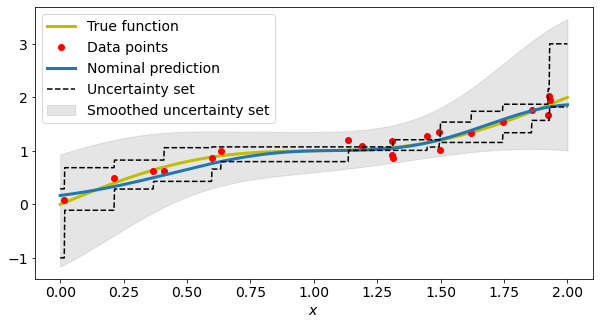

In [9]:
plt.figure(figsize=(10,5))
matplotlib.rcParams.update({'font.size': 14})

plt.plot(xs, ys, '-y', label="True function", linewidth=3)
plt.plot(xs_train, ys_train, 'ro', label="Data points")
plt.plot(xs, K_plot@alpha_pred, label="Nominal prediction", linewidth=3)

plt.plot(xs, [ub(x) for x in xs], 'k--', label= "Uncertainty set")
plt.plot(xs, [lb(x) for x in xs], 'k--')

K_eval = psi0(xs.reshape([-1,1])-xs_grid.reshape([1,-1]))
plt.fill_between(xs, 
                 (K_eval@alpha_lower).flatten(), 
                 (K_eval@alpha_upper).flatten(), 
                 color='gray', 
                 alpha=0.2, 
                 label= "Smoothed uncertainty set")

plt.xlabel("$x$")
plt.legend()
plt.savefig('output/example_monotonic.pdf', bbox_inches="tight")

## Additional plotting

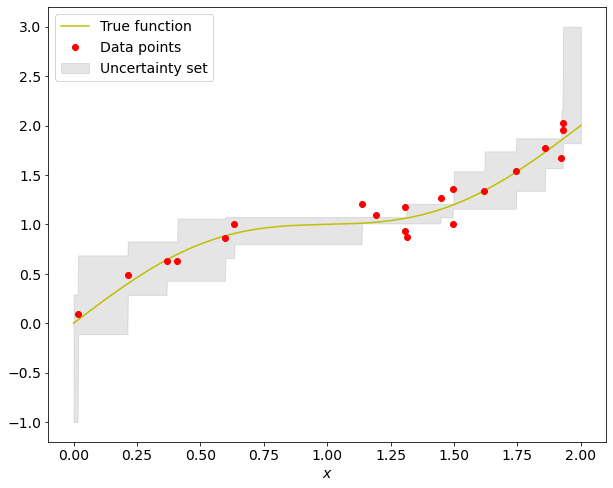

In [10]:
plt.figure(figsize=(10,8))
plt.plot(xs, ys, '-y', label='True function')
plt.plot(xs_train, ys_train, 'ro', label='Data points')

#plt.plot(xs, [ub(x) for x in xs], 'k')
#plt.plot(xs, [lb(x) for x in xs], 'k')
plt.fill_between(xs, 
                 [lb(x) for x in xs], 
                 [ub(x) for x in xs], 
                 color='gray', 
                 alpha=0.2, 
                 label='Uncertainty set')
plt.legend(loc='upper left')
plt.xlabel('$x$')
plt.savefig('output/example_monotonic_talk_uncertaintysets.pdf', bbox_inches="tight")

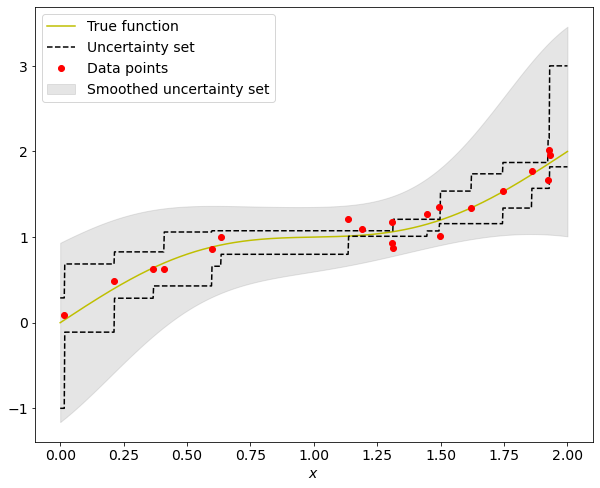

In [11]:
plt.figure(figsize=(10,8))
plt.plot(xs, ys, '-y', label='True function')
plt.plot(xs, [ub(x) for x in xs], 'k--', label= "Uncertainty set")
plt.plot(xs, [lb(x) for x in xs], 'k--')
plt.plot(xs_train, ys_train, 'ro', label='Data points')

K_eval = psi0(xs.reshape([-1,1])-xs_grid.reshape([1,-1]))
plt.fill_between(xs, 
                 (K_eval@alpha_lower).flatten(), 
                 (K_eval@alpha_upper).flatten(), 
                 color='gray', 
                 alpha=0.2, 
                 label= "Smoothed uncertainty set")

plt.legend(loc='upper left')
plt.xlabel('$x$')
plt.savefig('output/example_monotonic_talk_smoothed.pdf', bbox_inches="tight")